# La nueva normalidad del crimen en la CDMX

El propósito de este artículo es visualizar los cambios en incidencia delictiva raíz de la pandemia de COVID-19.
Para ello, usaremos los datos de las carpetas de invertigacion de la PGJ de la CDMX, así como mapas a nivel AGEB y delegación.

Contenido:
- Lectura y limpieza
- Evolución temporal agregada
- Cambios por delegación
- Cambios en los focos rojos de la ciudad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import descartes
import math

from datetime import datetime
from collections import Counter

from sklearn.cluster import DBSCAN

## Lectura y limpieza

In [2]:
datos = pd.read_csv('inputs/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico.csv')
datos.head()

ao_hechos mes_hechos         fecha_hechos  \
0     2017.0    Octubre  2017-10-06 12:00:00   
1     2017.0  Noviembre  2017-11-15 20:00:00   
2     2017.0  Noviembre  2017-11-15 18:30:00   
3     2017.0  Noviembre  2017-11-15 17:32:00   
4     2017.0  Noviembre  2017-11-14 19:00:00   

                                       delito  \
0                                      FRAUDE   
1         PERDIDA DE LA VIDA POR OTRAS CAUSAS   
2  ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA   
3           ROBO DE MOTOCICLETA CON VIOLENCIA   
4        ROBO A CASA HABITACION SIN VIOLENCIA   

                       categoria_delito                         fiscalia  \
0                DELITO DE BAJO IMPACTO    INVESTIGACIÓN EN AZCAPOTZALCO   
1                    HECHO NO DELICTIVO         INVESTIGACIÓN EN TLALPAN   
2                DELITO DE BAJO IMPACTO      INVESTIGACIÓN EN IZTAPALAPA   
3  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  INVESTIGACIÓN EN MIGUEL HIDALGO   
4                DELITO DE BAJO IMPACTO      INVESTIGACIÓN EN IZTAPALAPA   

  agencia unidad_investigacion alcaldia_hechos  \
0    AZ-1               UI-3SD      IZTAPALAPA   
1   TLP-2               UI-3CD         TLALPAN   
2   IZP-4               UI-3SD      IZTAPALAPA   
3    MH-2               UI-1SD  MIGUEL HIDALGO   
4   IZP-9               UI-3SD      IZTAPALAPA   

                         colonia_hechos  ao_inicio mes_inicio  \
0                              APATLACO       2017  Noviembre   
1             MIGUEL HIDALGO 2A SECCIÓN       2017  Noviembre   
2              DR. ALFONSO ORTIZ TIRADO       2017  Noviembre   
3                     LOMAS DE SOTELO I       2017  Noviembre   
4  2A. AMPLIACIÓN SANTIAGO ACAHUALTEPEC       2017  Noviembre   

          fecha_inicio              calle_hechos  calle_hechos2   longitud  \
0  2017-11-15 20:14:33            REAL DEL MONTE            NaN -99.116256   
1  2017-11-15 20:15:06             JESUS LECUONA         OAXACA -99.193514   
2  2017-11-15 20:18:33        SAN RAFAEL ATLIXCO            NaN -99.073700   
3  2017-11-15 20:19:27  AV. INGENIEROS MILITARES            NaN -99.217985   
4  2017-11-15 20:20:20                EVA SAMANO  LEONA VICARIO -99.012944   

     latitud                      geopoint  
0  19.380585  19.3805845107,-99.1162559436  
1  19.286033  19.2860327788,-99.1935140733  
2  19.387269  19.3872690138,-99.0736999107  
3  19.453354  19.4533537449,-99.2179851004  
4  19.347705   19.3477045484,-99.012944086

Para revisar la calidad de estos datos, haremos lo siguiente:

- La unicidad por categoría: si los registros fueron hechos a mano se presta a que haya más de un registro por faltas de ortografía (por ejemplo, COYOACAN y COYOACÁN)

- La cantidad de datos por categoría: se observa información hasta 1901, pero es probable que solo sea un hecho histórico registrado para ese año y no se tengan registros para años intermedios. Dado que tras observar la serie de tiempo se nota un incremento sustancial exactamente al iniciar 2016, lo cual se debe deber a un tema de registros, sólo consrvaremos la información disponible a partir de ese momento.

- Convertimos las fechas a formato fecha. Para los valores faltantes tomamos la fecha de la variable fecha_inicio

- Sólo conservamos datos de delitos ocurridos en la CDMX

In [3]:
#solo conservamos regiones de la cdmx

datos=datos[datos['alcaldia_hechos']\
            .isin(datos[['alcaldia_hechos','delito']]\
                  .groupby('alcaldia_hechos')\
                  .count().sort_values(by='delito',ascending=False)[:16].index)]\
    .reset_index().drop(columns='index')

# fechas

datos['fecha']=datetime.strptime('2000-12-31 10:10','%Y-%m-%d %H:%M').date()
datos['aux']=datos['fecha_hechos'].apply(lambda x: str(x)[2])

#limpios
aux_num=['0','1','2','3','4','5','6','7','8','9']
datos.loc[datos['aux'].isin(aux_num),'fecha']=datos.loc[datos['aux'].isin(aux_num),'fecha_hechos']\
    .apply(lambda x: str(x)[:16])\
    .str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

del aux_num

#n, se reemplazan por fecha_inicio que fluye sin problema
datos.loc[datos['aux']=='n','fecha']=datos.loc[datos['aux']=='n','fecha_inicio']\
    .apply(lambda x: str(x)[:16])\
    .str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

#/, solo tienen un formato de prsentación distinto
datos.loc[datos['aux']=='/','fecha']=datos.loc[datos['aux']=='/','fecha_hechos']\
    .apply(lambda x: str(x)[:16]).str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M').date())

datos.loc[datos['aux']==' ','auxx']=datos.loc[datos['aux']==' ','fecha_inicio']\
    .apply(lambda x: str(x)[2])

datos.loc[datos['auxx'].isin(['/','-']),'fecha']=datos.loc[datos['auxx'].isin(['/','-']),'fecha_inicio']\
    .apply(lambda x: str(x)[:16]).str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%d-%m-%Y %H:%M').date())

aux_num=['0','1','2','3','4','5','6','7','8','9']
datos.loc[datos['auxx'].isin(aux_num),'fecha']=datos.loc[datos['auxx'].isin(aux_num),'fecha_inicio']\
    .apply(lambda x: str(x)[:16]).str.replace('/','-').str.replace('T',' ')\
    .apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M').date())

del aux_num

# mas fechas

datos=datos.drop(columns=['aux','auxx'])
datos['mes_ano']=datos['fecha'].apply(lambda x: datetime.strptime((str(x.year))+'-'+str(x.month)+'-01','%Y-%m-%d').date())

datos=datos[datos['fecha']>=datetime.strptime('01-01-2016','%d-%m-%Y').date()]

datos['semana']=datos['fecha'].apply(lambda x: x.strftime("%U"))

## Evolución temporal agregada

Se propone comparar la incidencia de diferentes tipos de delitos antes y después de la llegada de la pandemia. Para ello, primero debemos determinar los conjuntos de información elegidos para cada período.

Para el período con COVID es bastante simple, pues sólo tenemos que ubicar el momento a partir del cuál la gente comenzó su confinamiento. Los datos muestran de manera clara la fecha en la que esto ocurrió: Abril.
Casi todos los delitos disminuyen durante la primera mitad del año, debido a los efectos de la pandemia. Su posterior crecimiento y en algunos casos estabilización podrían considerarse como la "nueva normalidad".

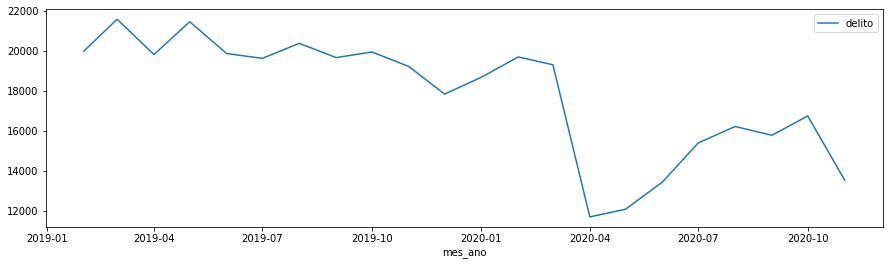

In [29]:
datos.loc[ (datos['fecha']>datetime.strptime('01-01-2018','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-01-2021','%d-%m-%Y').date()),
          ['mes_ano','delito']]\
    .groupby('mes_ano')\
    .count()\
    .plot(figsize=(15,4));

Para la determinación del período pre-COVID, lo más sencillo sería mantener todas las observaciones anteriores. Sin embargo, a pesar de que la información observada no muestra un choque releveante en la incidencia delictiva, han ocurrido cambios estructurales que obligan a hacer una exploración adicional.

En particular, valdría la pena buscar por cambios en patrones a raíz de la llegada de Claudia Sheinbaum a la jefatura de gobierno.

Desglosando los casos por tipo de delito podemos observar grandes cambios en sus respectivas categorías a lo largo del tiempo. Esto se puede deber a cambios en la estrategia de seguridad del gobierno, pero los cambios más grandes probablemente se deban a cambios en las tipificaciones de los delitos.

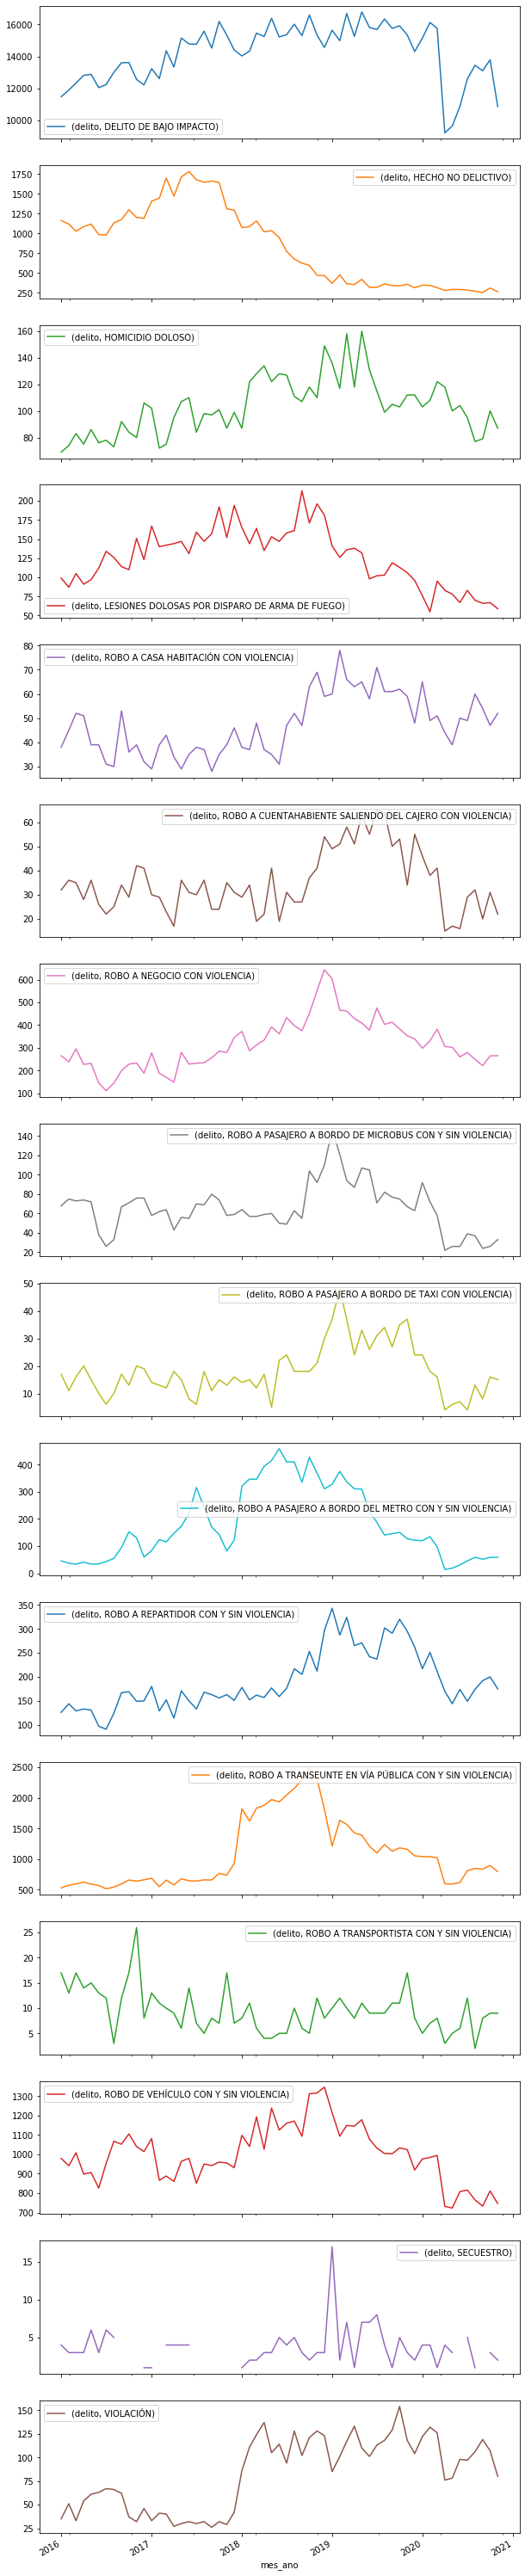

In [9]:
#datos.loc[datos['mes_ano']>=datetime.strptime('01-01-2020','%d-%m-%Y').date(),['mes_ano','categoria_delito','delito']]\
datos.loc[:,['mes_ano','categoria_delito','delito']]\
    .groupby(['mes_ano', 'categoria_delito'])\
    .count()\
    .unstack()\
    .plot(subplots=True,figsize=(10,60));

En la mayoría de los casos podemos observar cierta estabilidad, o al menos una tendencia sin grandes cambios, en el período a partir del cual llega Sheinbaum. Tomando en consideración posibles choques temporales derivados de la transición de gobierno, tomaremos la información 3 meses después de la toma de posesión de Sheinbaum, es decir, a aprtir de febrero de 2019.

In [10]:
datos=datos[datos['fecha']>=datetime.strptime('01-02-2019','%d-%m-%Y').date()].reset_index()

Como análisis posterior se considera hacer pruebas de cambios de tendencia de series de tiempo de Perron.

## Cambios por delegación

Ahora, pasaremos a ver el cambio en incidencia delictiva per capita de cada tipo de crimen por delegación.

Se tomó la base de Indicadores de Peligro, Exposición y Vulnerabilidad a nivel AGEB del Atlas de Riesgo de la ciudad, con datos de población de 2010 (http://www.atlas.cdmx.gob.mx/datosabiertos.html). Posteriormente, se agregó la información al nivel de delegación, con una mapa de municipalidades de CONABIO (http://www.conabio.gob.mx/informacion/metadata/gis/muni_2018gw.xml?_httpcache%20=%20yes&_xsl=/db/metadata/xsl/fgdc_html.xsl&_indent%20=%20no) para el que conservamos únicamente el terriotorio correspondiente a la CDMX.

Para compararlos, tomaremos el mismo periodo de tiempo para cada año. Basándonos en los datos observados durante la pandemia, conservaremos la información de junio a noviembre, puesto que a partir de junio se "recuperó" la incidencia delictiva en la ciudad. De manera análoga, conservaremos los mismos meses para 2019 y los tomaremos como el periodo anterior.

In [494]:
mapa = gpd.read_file("inputs/mapa_cdmx_ageb")
mapa.head()
#[['ID','ENTIDAD','ALCALDIA','CVEGEO','AREA_M2','POB_TOT','geometry']]

In [495]:
mapa_del = gpd.read_file("inputs/mapa_cdmx_del")
mapa_del = mapa_del[mapa_del['CVE_ENT']=='09']
mapa_del.head()

CVE_ENT CVE_MUN CVEGEO            NOM_ENT        AREA  PERIMETER  \
270      09     002  09002  Ciudad de MÃ©xico  3332.30920   33.32309   
271      09     003  09003  Ciudad de MÃ©xico  5362.23142   53.62231   
272      09     004  09004  Ciudad de MÃ©xico  7107.11186   71.07112   
273      09     005  09005  Ciudad de MÃ©xico  8737.83072   87.37831   
274      09     006  09006  Ciudad de MÃ©xico  2296.27846   22.96278   

                   NOM_MUN  COV_  COV_ID  \
270           Azcapotzalco   270     271   
271              CoyoacÃ¡n   271     272   
272  Cuajimalpa de Morelos   272     273   
273      Gustavo A. Madero   273     274   
274              Iztacalco   274     275   

                                              geometry  
270  POLYGON ((-99.15718110987984 19.50284889026444...  
271  POLYGON ((-99.13983600039167 19.35691759942204...  
272  POLYGON ((-99.25580791004975 19.40357242033058...  
273  POLYGON ((-99.11788785021801 19.59059231026297...  
274  POLYGON ((-99.05578649038294 19.42214109034302...

In [496]:
mapa['CVE_ALCALDIA']=mapa['CVEGEO'].str.slice(0,5)

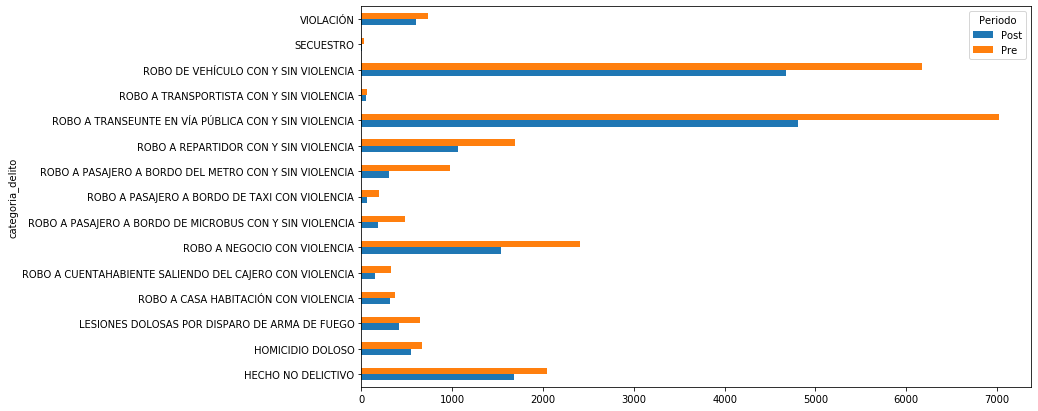

In [480]:
#Por desgracia los datos de población no son muy estables, por lo que descartamos las AGEBs con menos de 600 habitantes para quitar observaciones sin información y con poca gente que tienen mucha varianza. Esto representa menos del 7% de las AGEBs, por lo que se conserva una parte sustancial del mapa.
datos['Periodo']='ninguno'
datos.loc[(datos['fecha']>=datetime.strptime('01-06-2019','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-12-2019','%d-%m-%Y').date()),'Periodo']='Pre'
datos.loc[(datos['fecha']>=datetime.strptime('01-06-2020','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-12-2020','%d-%m-%Y').date()),'Periodo']='Post'

datos_periodos=datos[['delito','categoria_delito','Periodo']].groupby(['categoria_delito','Periodo']).count().reset_index()

datos_periodos[(datos_periodos['categoria_delito']!='DELITO DE BAJO IMPACTO') & (datos_periodos['Periodo']!='ninguno')]\
    .pivot("categoria_delito", "Periodo", "delito")\
    .plot(kind='barh',figsize=(12,7))

In [537]:
# genera base con sus puntos
points = gpd.GeoDataFrame(datos.loc[:,['longitud','latitud','categoria_delito','delito','Periodo']],
                          geometry=gpd.points_from_xy(datos.loc[:,'longitud'],
                                                      datos.loc[:,'latitud']))
points=points[points.is_valid]

# puntos con info de su delegacion
cruce_aux=gpd.sjoin(points,mapa_del,how='left',op='within')

# al mapa se le añaden conteos de crimenes por zona y pob total
mapa_del_ambos=mapa_del.merge(cruce_aux[['CVEGEO','categoria_delito','delito','Periodo']]\
                            .groupby(['CVEGEO','categoria_delito','Periodo'])\
                            .count().reset_index(),
                         on='CVEGEO',how='left')\
    .merge(mapa[['CVE_ALCALDIA','ALCALDIA','POB_TOT']].groupby(['CVE_ALCALDIA','ALCALDIA']).sum().reset_index(),
          how='left',left_on='CVEGEO',right_on='CVE_ALCALDIA')
# tasa de crimen por zona
mapa_del_ambos['tasa_delito']=mapa_del_ambos['delito']/mapa_del_ambos['POB_TOT']*100000

del points
del cruce_aux

mapa_del_ambos.head()

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [539]:
datos_periodos_del=mapa_del_ambos.loc[mapa_del_ambos['Periodo']!='ninguno',['Periodo','categoria_delito','ALCALDIA','tasa_delito']]

In [541]:
aux_intervalos=datos_periodos_del[datos_periodos_del['Periodo']!='ninguno'].groupby('categoria_delito').min().reset_index()[['categoria_delito','tasa_delito']].rename(columns={'tasa_delito':'min'})\
.merge(
    datos_periodos_del[datos_periodos_del['Periodo']!='ninguno'].groupby('categoria_delito').max().reset_index()[['categoria_delito','tasa_delito']].rename(columns={'tasa_delito':'max'}),
)

In [542]:
aux_intervalos

categoria_delito         min          max
0                              DELITO DE BAJO IMPACTO  534.408188  2642.756816
1                                  HECHO NO DELICTIVO    9.348566    74.647773
2                                    HOMICIDIO DOLOSO    1.297222    11.093750
3       LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO    0.838012     6.028294
4                ROBO A CASA HABITACIÓN CON VIOLENCIA    1.509628     9.657533
5   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...    0.780587    16.895108
6                        ROBO A NEGOCIO CON VIOLENCIA    3.019255    64.630493
7   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...    0.461541    19.774879
8       ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA    0.241132     6.972584
9   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...    0.550449    66.562498
10              ROBO A REPARTIDOR CON Y SIN VIOLENCIA    1.073059    33.253864
11  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   17.360718   186.713448
12           ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA    0.242083     3.248426
13               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   20.388126   107.928881
14                                          SECUESTRO    0.165218     0.835259
15                                          VIOLACIÓN    2.933043    13.350106

A continuación se meustra una serie de mapas para observar la incidencia delicitiva por tipo de crimen y delegación.
De este podemos sacar algunas conclusiones:

- La mayoría de los delitos se encuentran concentrados en la zona centro, aún tomando las variables per cápita.
- El robo en microbus se concentra al este de la ciudad, cuya zona es colindante con Ecatepec del Estado de México. De manera similar, el robo a transportista coincide. Para este se podría ocnsiderar que se debe a que en ambos sitios se ubican los flujos de vehiculos fuera de la ciudad.
- El asalto a negocio y en cajeros se concentra al oeste de la ciudad. Sobre el segundo delito, convendría conocer la distribución de los cajeros en la ciudad, dado que el oeste es una zona de gran actividad económica.
- El secuestro se concentra al sureste de la ciudad (Milpa Alta). Dos puntos que hay que tener en cuenta es que es una zona cercana al Estado de México y poco desarrollada comparada al resto de la ciudad, y la zona tiene una muy baja densidad de población.

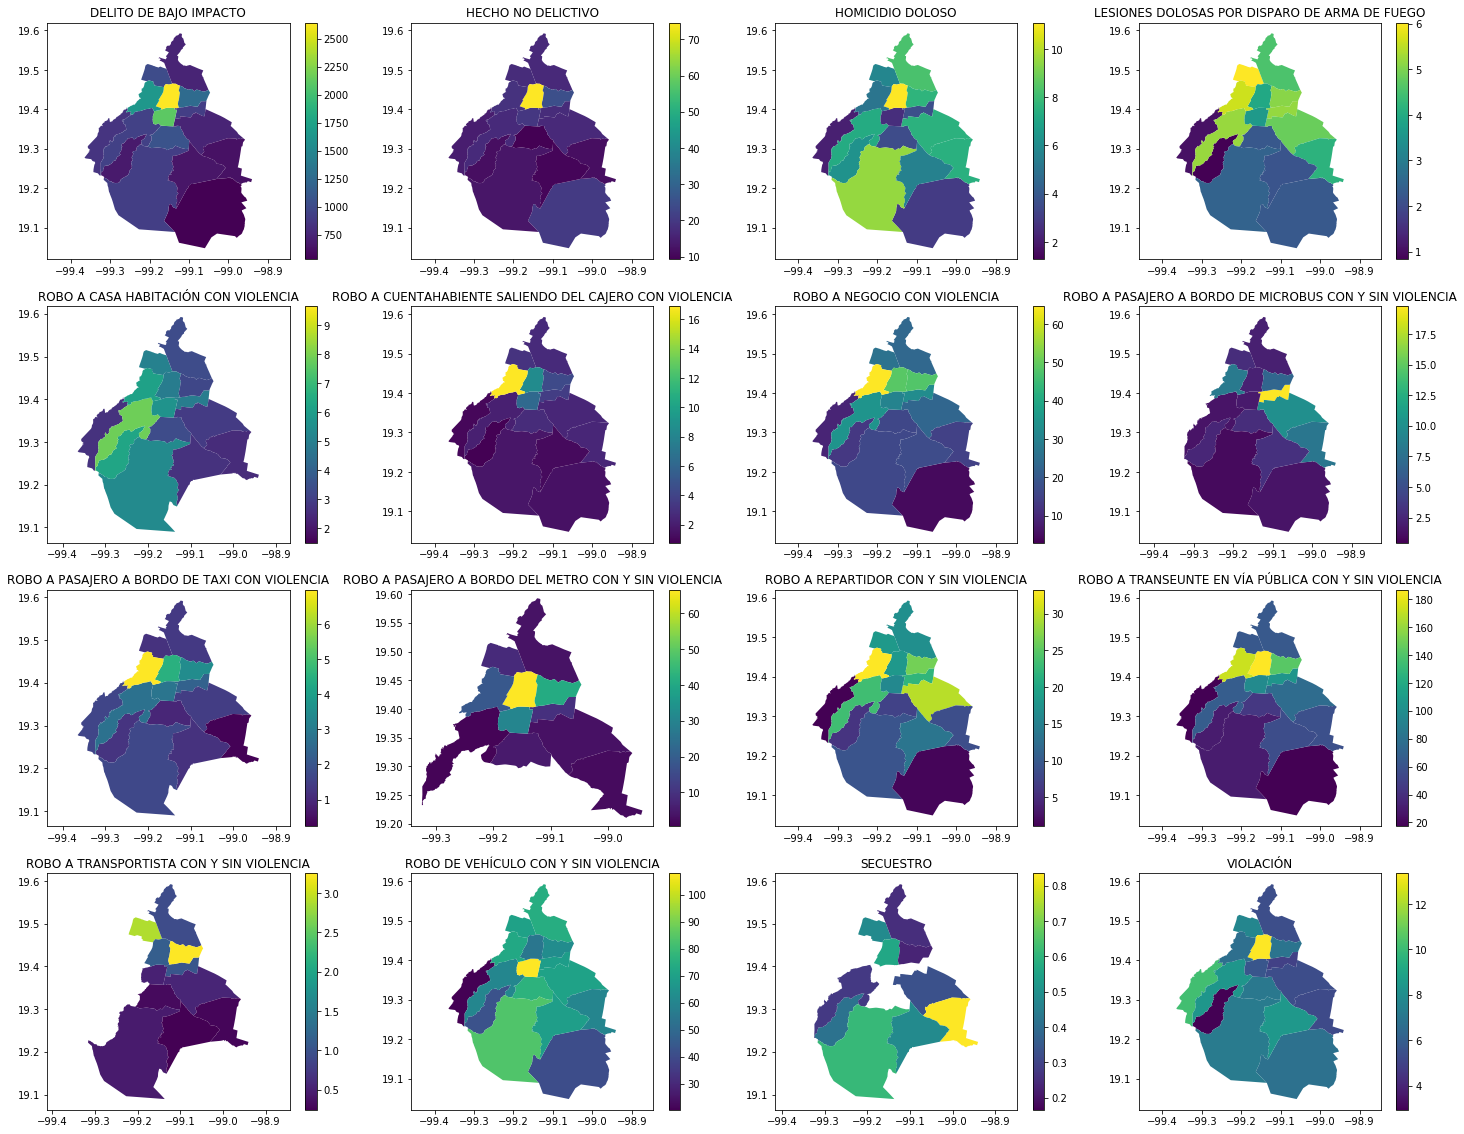

In [545]:
aux = mapa_del_pre.groupby('categoria_delito')

plt.figure(figsize=(25,20))

# itera por delitos
for i, (aux_name, aux_gdf) in enumerate(aux):
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(4, 4, i + 1) # nrows, ncols, axes position
    # plot the continent on these axes
    aux_gdf.plot(ax=ax,column='tasa_delito',legend=True,
                 vmin=aux_intervalos.loc[aux_intervalos['categoria_delito']==aux_name,'min'],
                 vmax=aux_intervalos.loc[aux_intervalos['categoria_delito']==aux_name,'max'])
    # set the title
    ax.set_title(aux_name)
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')

del aux
plt.show()

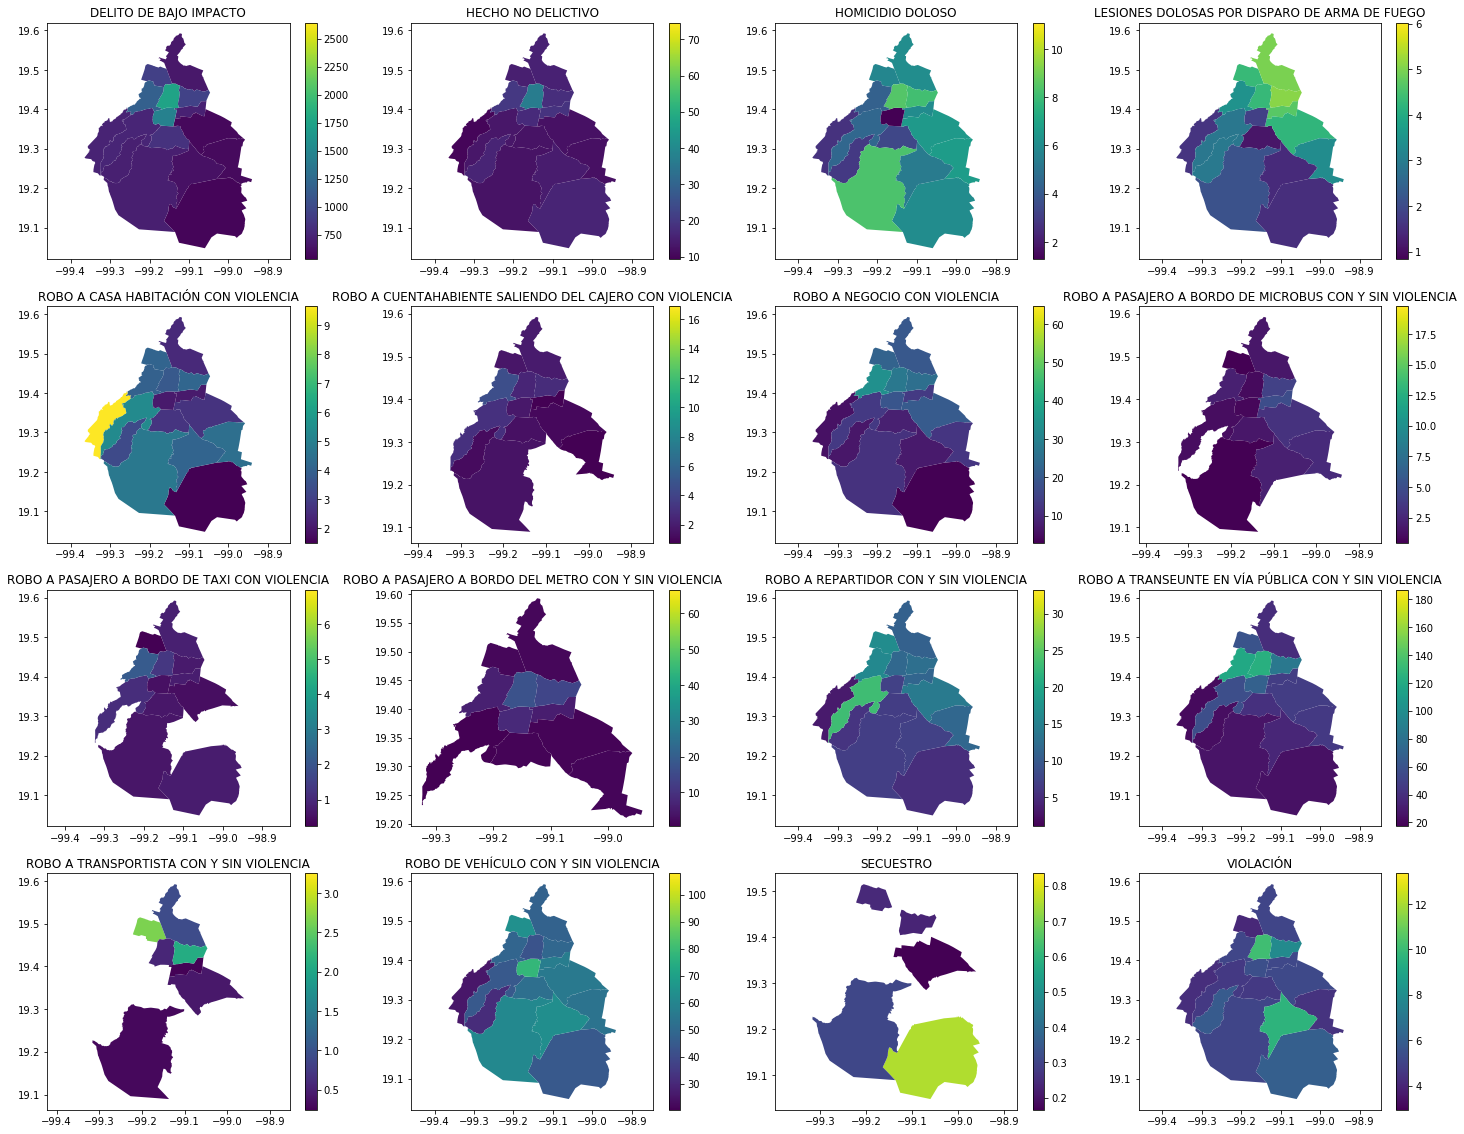

In [547]:
aux = mapa_del_post.groupby('categoria_delito')

plt.figure(figsize=(25,20))

# itera por delitos
for i, (aux_name, aux_gdf) in enumerate(aux):
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(4, 4, i + 1) # nrows, ncols, axes position
    # plot the continent on these axes
    aux_gdf.plot(ax=ax,column='tasa_delito',legend=True,
                 vmin=aux_intervalos.loc[aux_intervalos['categoria_delito']==aux_name,'min'],
                 vmax=aux_intervalos.loc[aux_intervalos['categoria_delito']==aux_name,'max'])
    # set the title
    ax.set_title(aux_name)
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')

del aux
plt.show()

In [63]:
datos_respaldo=datos.copy()

datos = datos[(datos['fecha']>=datetime.strptime('01-06-2020','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-12-2020','%d-%m-%Y').date())]

In [238]:
datos_respaldo_2=datos.copy()
datos=datos_respaldo.copy()

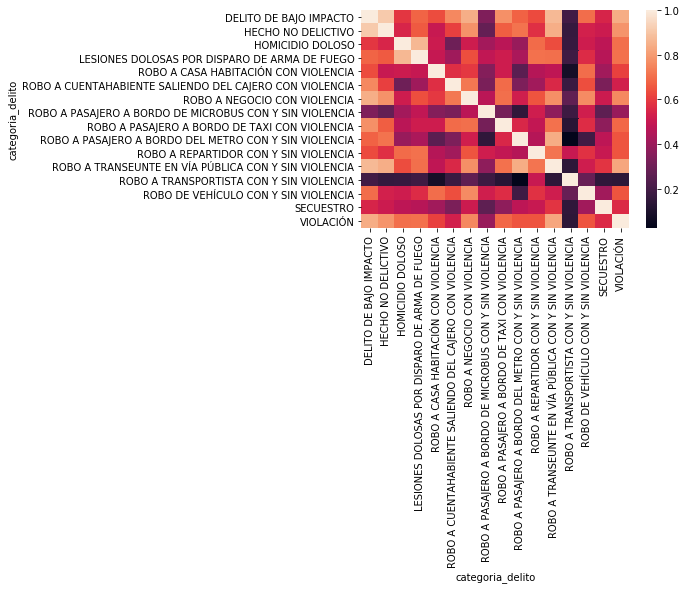

In [49]:
#from collections import Counter
sns.heatmap(pd.DataFrame(datos[['categoria_delito','delito','colonia_hechos']].groupby(['categoria_delito','colonia_hechos']).count()).reset_index()\
    .pivot(index='colonia_hechos',columns='categoria_delito',values='delito').fillna(0).corr())

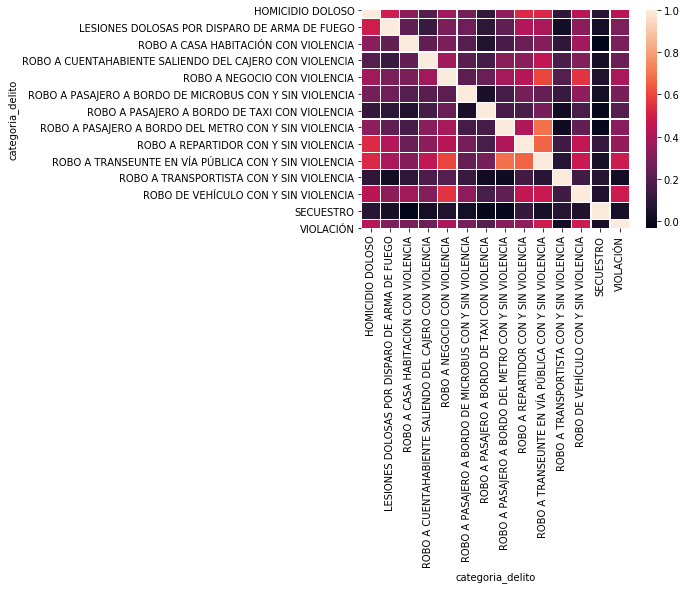

In [220]:
sns.heatmap(pd.DataFrame(datos.loc[~datos['categoria_delito'].isin(['DELITO DE BAJO IMPACTO','HECHO NO DELICTIVO']),['categoria_delito','delito','colonia_hechos']]\
                         .groupby(['categoria_delito','colonia_hechos']).count()).reset_index()\
    .pivot(index='colonia_hechos',columns='categoria_delito',values='delito').fillna(0).corr(),
           annot=False,linewidths=.2)

## Focos rojos

Por último, algo interesante sería ver, a nivel más desagregado, qué zonas son focos rojos actualmente.
Una hipótesis podría ser que las zonas de aglomeración de actividades no escenciales que fueron cerradas por la pandemia cayeron en su índice de incidencia delictiva sustancialmente, mientras que los robos a casa habitación con violencia o similares aumentaron.

Para esto, mostraremos la ubicación de cada crimen en la ciudad y buscaremos construir conjuntos de los mismos mediante BDSCAN, una técnica de aprendizaje no supervisado.

In [ ]:
points = gpd.GeoDataFrame(datos.loc[datos['Periodo']=='Post',['longitud','latitud','categoria_delito','delito','Periodo']],
                          geometry=gpd.points_from_xy(datos.loc[datos['Periodo']=='Post','longitud'],
                                                      datos.loc[datos['Periodo']=='Post','latitud']))
points=points[points.is_valid]

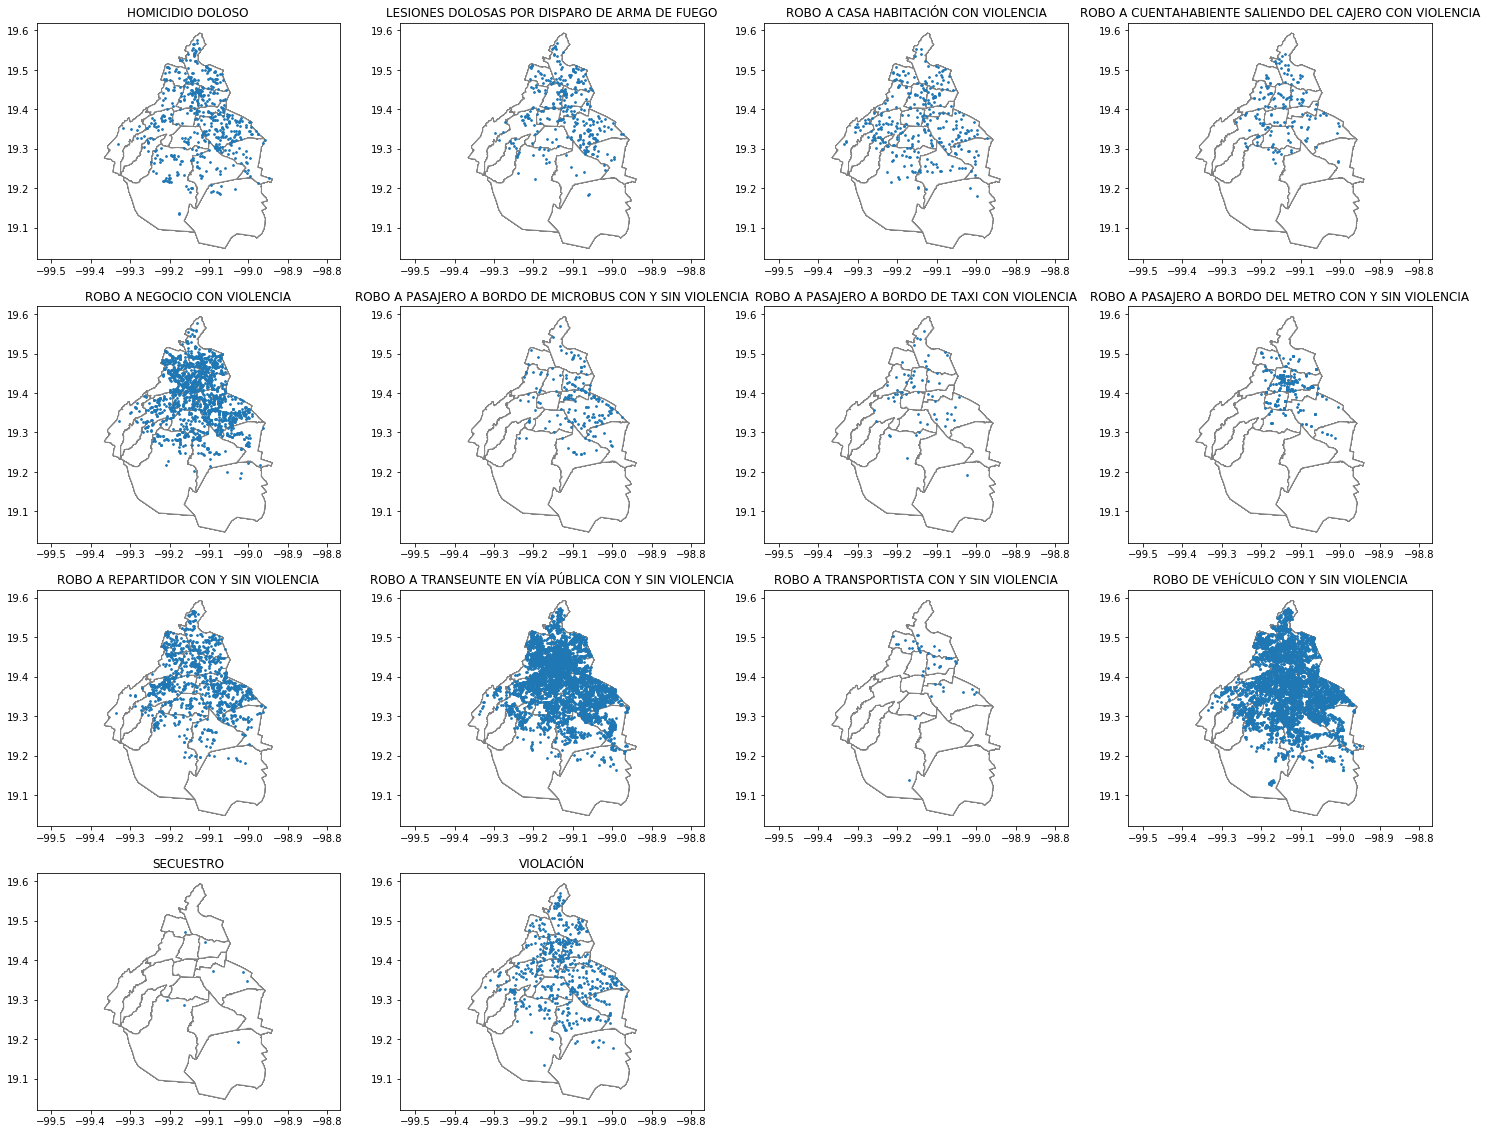

In [236]:
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
aux = points.groupby('categoria_delito')

plt.figure(figsize=(25,20))

# Iterate through auxs


for i, (aux_name, aux_gdf) in enumerate(aux):
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(4, 4, i + 1) # nrows, ncols, axes position
    # plot the aux on these axes
    mapa_del.plot(ax=ax,color='white', edgecolor='grey')
    aux_gdf.plot(ax=ax,markersize=3)
    # set the title
    ax.set_title(aux_name)
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')

del aux

plt.show()

In [479]:
datos[(datos['Periodo']=='Post')][['categoria_delito','delito']]\
    .groupby('categoria_delito').count().reset_index()

categoria_delito  delito
0                              DELITO DE BAJO IMPACTO   74703
1                                  HECHO NO DELICTIVO    1676
2                                    HOMICIDIO DOLOSO     542
3       LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO     412
4                ROBO A CASA HABITACIÓN CON VIOLENCIA     312
5   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...     150
6                        ROBO A NEGOCIO CON VIOLENCIA    1538
7   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...     185
8       ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA      63
9   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...     306
10              ROBO A REPARTIDOR CON Y SIN VIOLENCIA    1064
11  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...    4806
12           ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA      46
13               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA    4679
14                                          SECUESTRO      11
15                                          VIOLACIÓN     607

Como se puede observar, hay muy pocos registros de secuestros y robos en taxi, por lo que omitiremos dichas categorías para el siguiente ejercicio, así como los delitos de bajo impacto y los hechos no delictivos.

In [460]:
#categorias_delitos=list(set(datos['categoria_delito']))

categorias_delitos=['ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
 'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
 'VIOLACIÓN',
 'ROBO A REPARTIDOR CON Y SIN VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
 'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
 'HOMICIDIO DOLOSO',
 'ROBO A CASA HABITACIÓN CON VIOLENCIA']

Para tener cierta perspectiva sobre las aglomeraciones, primero mostraremos un mapa de calor de población a nivel AGEB:

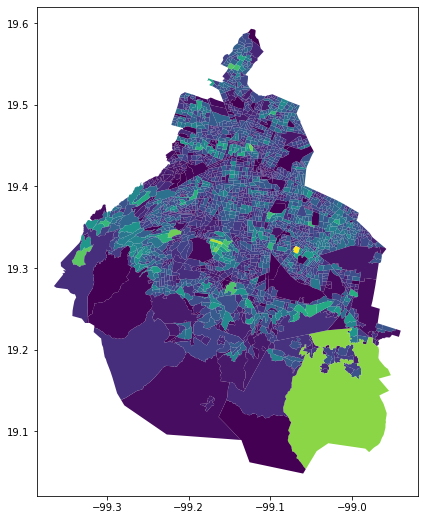

In [458]:
mapa.plot(column='POB_TOT',figsize=(11,9))

El algoritmo de BDSCAN toma como parámetros:
- La distancia máxima entre puntos para considerarlos dentro de un mismo cluster
- El número mínimo de observaciones dentro de un cluster para considerarlo un cluster

Para la distancia, tomamos 200 metros como la distancia adecuada para considerarlos dentro de una misma área. Para el número mínimo de observaciones, quizá con algunas objeciones válidas, se tomó el 2% del total de casos. 

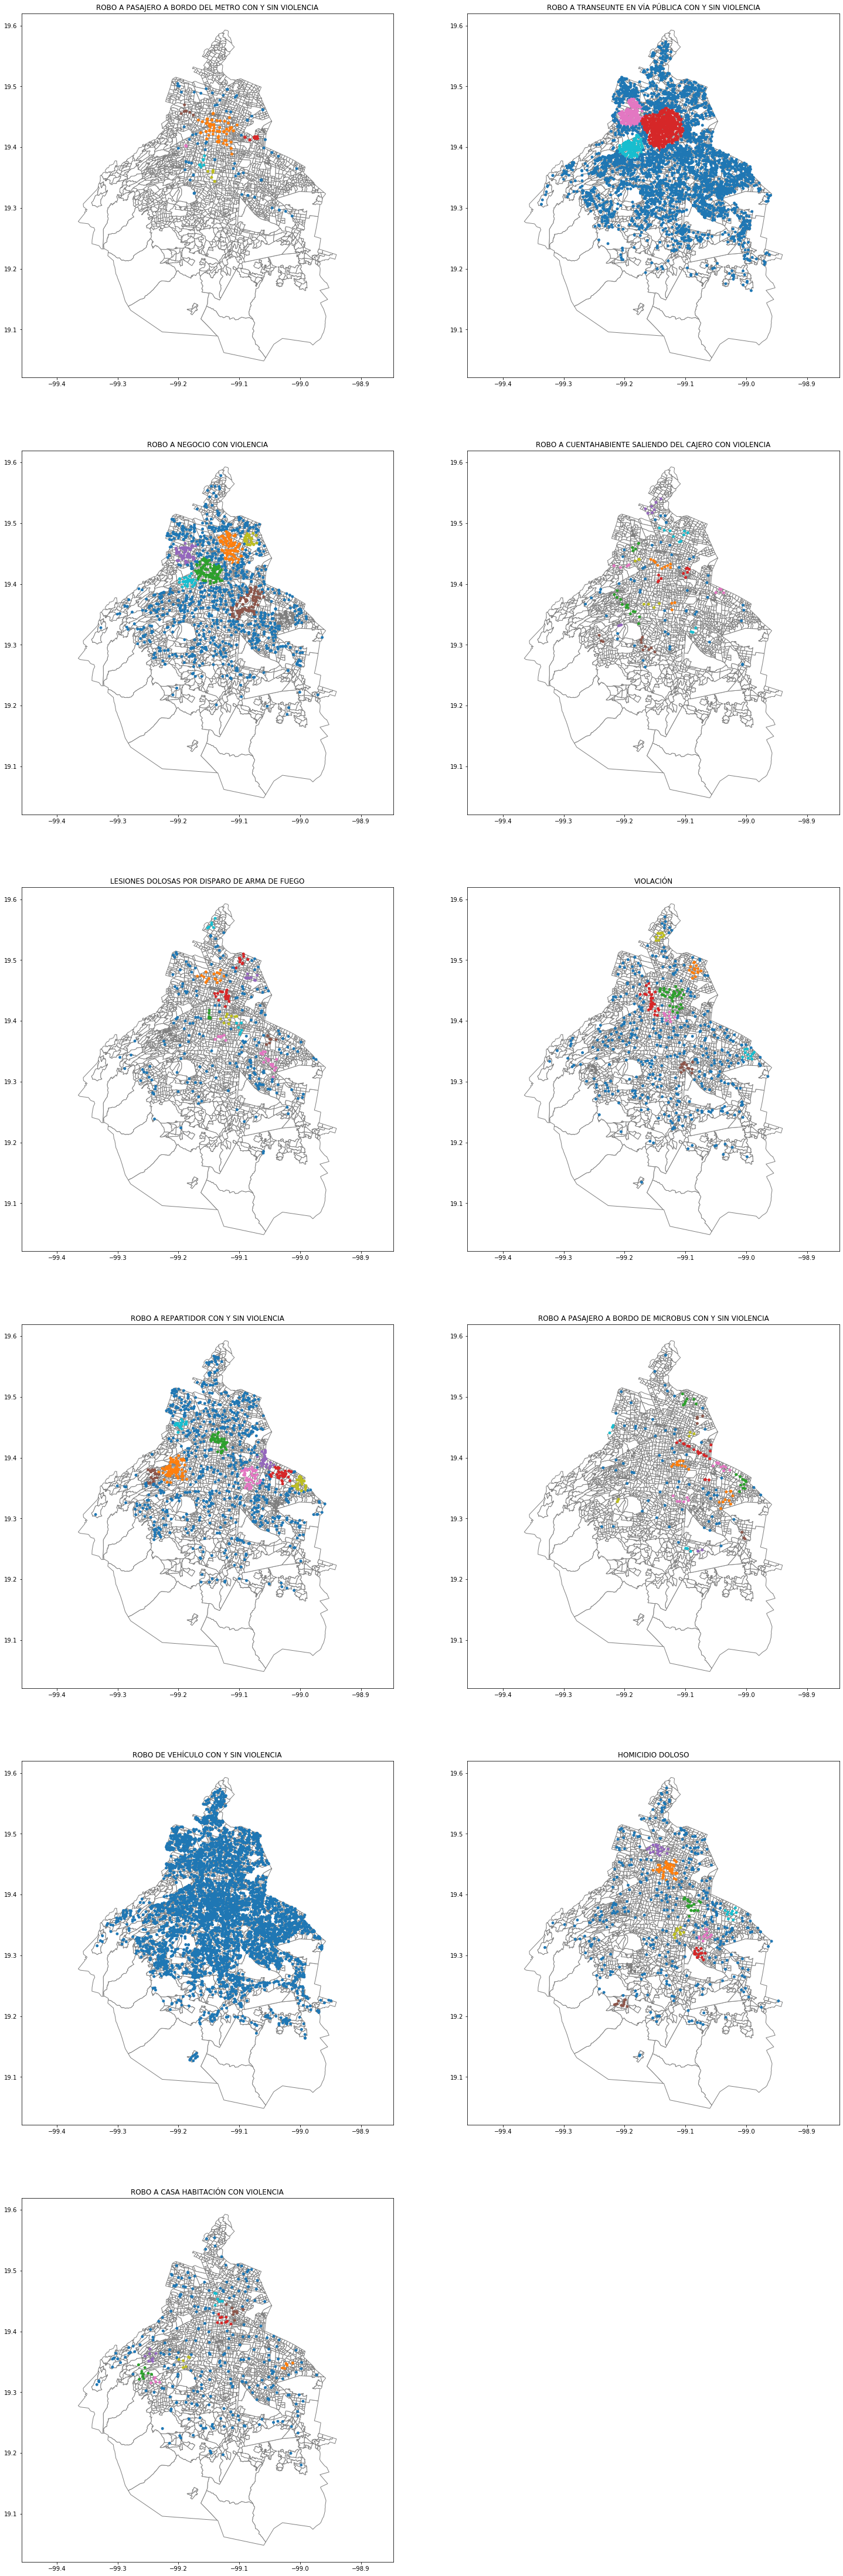

In [462]:

plt.figure(figsize=(25,80))

# Iterate through continents

for i in range(len(categorias_delitos)):
    
    points = gpd.GeoDataFrame(datos[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i])][['longitud','latitud','categoria_delito','delito']],
                          geometry=gpd.points_from_xy(datos.loc[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i]),'longitud'],
                                                      datos.loc[(datos['Periodo']=='Post')&(datos['categoria_delito']==categorias_delitos[i]),'latitud']))
    points=points[points.is_valid]
    clustering = DBSCAN(eps=.0115,min_samples=np.round(points.shape[0]*.02)).fit(np.array(points[['longitud','latitud']]))

    # create subplot axes in a 3x3 grid
    ax = plt.subplot(6, 2, i + 1) # nrows, ncols, axes position

    # plot the continent on these axes
    mapa.plot(ax=ax,color='white', edgecolor='grey')
    points.plot(ax=ax,markersize=15,column=clustering.labels_,categorical=True)
    # set the title
    ax.set_title(categorias_delitos[i])
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')

#plt.tight_layout()
plt.show()

De esta visualización podemos sacar algunos comentarios:
- Por obvias razones los casos de robo en el metro ocurren en áreas muy específicas. En este caso el algoritmo muestra un gran cluster en el centro, probablemente por el ismple hecho que hay muchas estaciones en dicha región.
- El robo a transeunte en vía pública muestra 3 conjuntos.
- Se observan concentraciones de violaciones en el centro del país, así como al norte y el este de la ciudad.
- Para robos en microbus el algoritmo no muestra conjuntos tan claros, pero esto no es tan necesario, dado que a simple vista se observa que las mayores concentraciones se observan en el este y en un corredor en la región noreste correspondiente a la calzada Ignacio Zaragoza.
- El robo de vehículo se encuentra bastante extendido a lo largo de la ciudad. Por ello, el algoritmo no muestra ningún punto de concentración en específico.
- Hay concentraciones de homicidios dolosos en el centro, el sur el norte y el este de la ciduad. En el centro podría explicarse por su densidad de población, mientras que la gran masa del este coincide con el hecho de que también tiene una alta densidad de población y que posee un nivel de marginación comparativamente mayor respecto al resto de la ciudad. Se puede decir algo similar del conjunto del centro.
- Para robo a casa habitación se detectan puntos de concentración en 3 zonas: al centro, un pequeño conjunto al este y un conjunto más grande al oeste. Este último podría apuntar a zonas residenciales de la región, que es una zona de alta capacidad económica. Sin embargo, la vasta mayoría se encuentran desperdigados a lo largo de la ciudad.

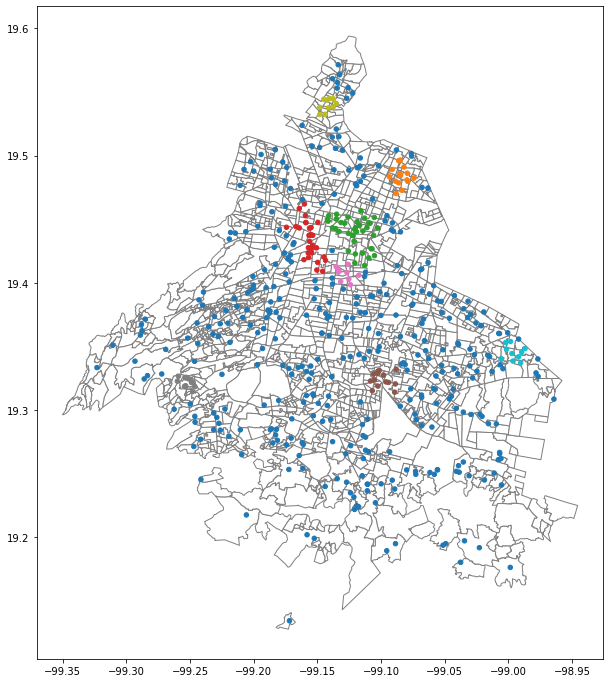

In [432]:
ax=mapa_col.plot(color='white',figsize=(15,12), edgecolor='grey')
#points.plot(ax=ax, color='red',markersize=1)
points.plot(ax=ax,column=clustering.labels_,figsize=(15,12),categorical=True,markersize=20)
plt.show()

## PCA fallido

Para esto, construiremos un índice de agregación del crimen por medio de componentes principales (PCA).

Tras aplicar una normalización de la información por medio de una transformación de potencia Yeo-Johnson, se encontró que el primer componente explica el 34% de la variación en la información, y los demás componentes explican menos del 10% en lo individual.

Dadas las opciones, se optó por trabajar con datos a nivel AGEB. Esto es un punto medio entre agregaciones muy grandes (delegación) o muy pequeñas (manzana), permitiendo que haya menos variación de información por nivel y a la vez una variedad de registros.

In [65]:
mapa_col = gpd.read_file("D:/coloniascdmx")
mapa_col = mapa_col[mapa_col['geometry'].notnull()]
mapa_col.head()

nombre  entidad  cve_alc        alcaldia  \
0                     LOMAS DE CHAPULTEPEC      9.0     16.0  MIGUEL HIDALGO   
1  LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC)      9.0     16.0  MIGUEL HIDALGO   
2                     DEL BOSQUE (POLANCO)      9.0     16.0  MIGUEL HIDALGO   
3               PEDREGAL DE SANTA URSULA I      9.0      3.0        COYOACAN   
4                                 AJUSCO I      9.0      3.0        COYOACAN   

  cve_col                                  secc_com  \
0  16-042  4924, 4931, 4932, 4935, 4936, 4940, 4987   
1  16-044                                      4963   
2  16-026                                      None   
3  03-135                   433, 500, 431, 513, 501   
4  03-128        376, 377, 378, 379, 404, 493,  498   

                       secc_par  \
0  4923, 4937, 4938, 4939, 4942   
1                          4964   
2                    4918, 4919   
3       424, 425, 426, 430, 499   
4                           374   

                                            geometry  
0  POLYGON ((-99.22017088373187 19.42803250649744...  
1  POLYGON ((-99.22967474076427 19.4140557307484,...  
2  POLYGON ((-99.2082100184801 19.4328156500052, ...  
3  POLYGON ((-99.14587387461441 19.31978692721501...  
4  POLYGON ((-99.15854038211513 19.33037639970334...

In [66]:
datos_in=datos.loc[~datos['categoria_delito'].isin(['DELITO DE BAJO IMPACTO','HECHO NO DELICTIVO'])]

points = gpd.GeoDataFrame(datos_in[['longitud','latitud','categoria_delito','delito']], geometry=gpd.points_from_xy(datos_in['longitud'],datos_in['latitud']))
points=points[points.is_valid]


In [137]:
datos_in=datos.loc[~datos['categoria_delito'].isin(['DELITO DE BAJO IMPACTO','HECHO NO DELICTIVO'])]

points = gpd.GeoDataFrame(datos_in[['longitud','latitud','categoria_delito','delito']], geometry=gpd.points_from_xy(datos_in['longitud'],datos_in['latitud']))
points=points[points.is_valid]

#cruce_aux=gpd.sjoin(points,mapa_col,how='left',op='within')
cruce_aux=gpd.sjoin(points,mapa,how='left',op='within')

datos_col=cruce_aux[['CVEGEO','categoria_delito','delito']]\
    .groupby(['CVEGEO','categoria_delito']).count().reset_index()\
    .pivot(index='CVEGEO', columns='categoria_delito', values='delito')\
    .fillna(0)

#del datos_in
#del points
#del cruce_aux

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [343]:
datos_col_respaldo=datos_col.copy()

In [344]:
datos_col=datos_col.reset_index()

(array([1.147e+03, 0.000e+00, 2.910e+02, 0.000e+00, 7.100e+01, 0.000e+00,
        1.600e+01, 0.000e+00, 4.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

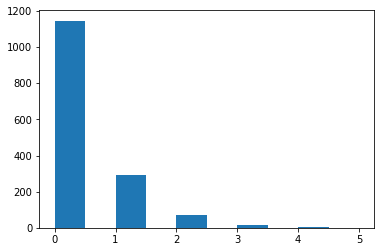

In [75]:
plt.hist(datos_col['VIOLACIÓN'])

In [266]:
mapa_plus['subtotal_delitos']=mapa_plus[['ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
 'SECUESTRO',
 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
 'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
 'VIOLACIÓN',
 'ROBO A REPARTIDOR CON Y SIN VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA',
 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
 'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
 'HOMICIDIO DOLOSO',
 'ROBO A CASA HABITACIÓN CON VIOLENCIA']].sum(axis=1)

In [280]:
mapa_plus['tasa_subtotal']=100000*mapa_plus['subtotal_delitos']/(mapa_plus['POB_TOT']+1)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


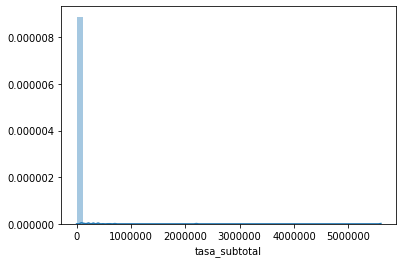

In [284]:
sns.distplot(mapa_plus['tasa_subtotal'])

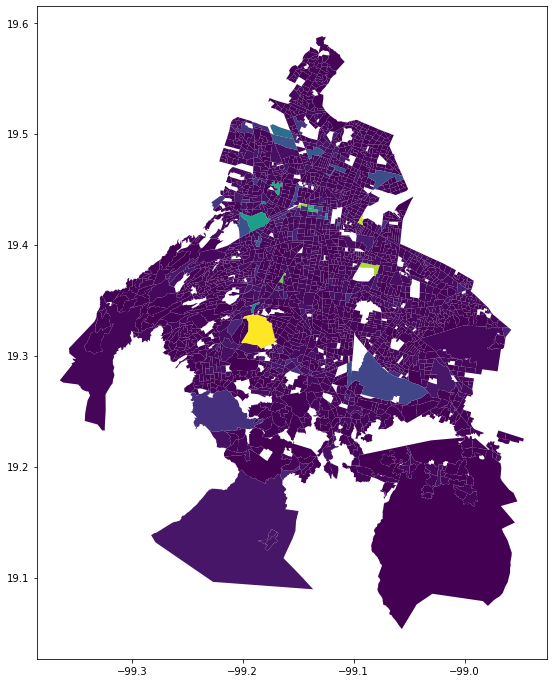

In [287]:
mapa_plus[mapa_plus['POB_TOT']>100].plot(column='tasa_subtotal',figsize=(15,12))

In [293]:
mapa_plus['subtotal_delitos'].min()

1.0

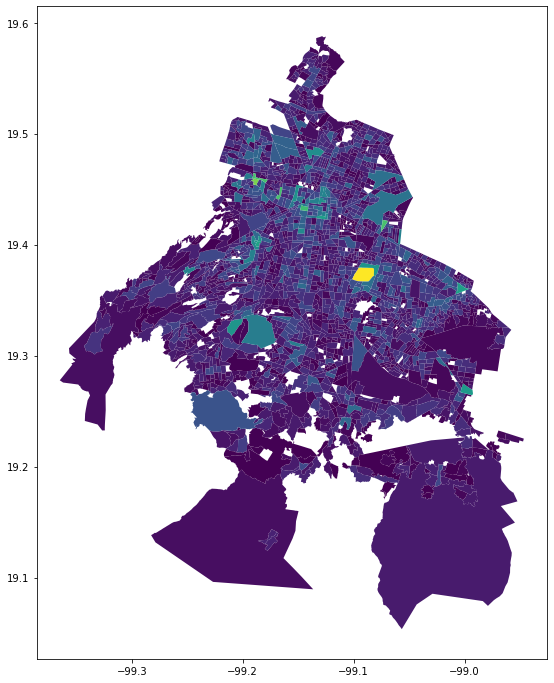

In [295]:
mapa_plus.plot(column='subtotal_delitos',figsize=(15,12))

In [267]:
mapa_plus

ID           ENTIDAD               ALCALDIA         CVEGEO  \
0        1.0  Ciudad de México             Xochimilco  0901300010495   
1        2.0  Ciudad de México             Xochimilco  0901300011455   
2        3.0  Ciudad de México             Xochimilco  0901300011402   
3        4.0  Ciudad de México             Xochimilco  0901300011120   
4        5.0  Ciudad de México          Benito Juárez  0901400010168   
5        6.0  Ciudad de México          Benito Juárez  0901400010488   
6        8.0  Ciudad de México          Benito Juárez  0901400010581   
7        9.0  Ciudad de México             Xochimilco  0901300011366   
8       10.0  Ciudad de México             Xochimilco  0901300010739   
9       11.0  Ciudad de México          Benito Juárez  0901400010562   
10      12.0  Ciudad de México          Benito Juárez  090140001037A   
11      13.0  Ciudad de México          Benito Juárez  0901400010115   
12      14.0  Ciudad de México          Benito Juárez  0901400010238   
13      15.0  Ciudad de México          Benito Juárez  090140001044A   
14      16.0  Ciudad de México          Benito Juárez  0901400010276   
15      17.0  Ciudad de México             Xochimilco  090130001064A   
16      18.0  Ciudad de México             Xochimilco  0901300010777   
17      20.0  Ciudad de México             Xochimilco  0901300010353   
18      21.0  Ciudad de México             Xochimilco  0901300010870   
19      22.0  Ciudad de México             Xochimilco  0901300011192   
20      23.0  Ciudad de México                Tlalpan  0901200010040   
21      24.0  Ciudad de México          Benito Juárez  0901400010613   
22      25.0  Ciudad de México          Benito Juárez  0901400010469   
23      27.0  Ciudad de México             Xochimilco  0901300010033   
24      28.0  Ciudad de México             Xochimilco  0901300011296   
25      30.0  Ciudad de México          Benito Juárez  090140001012A   
26      31.0  Ciudad de México          Benito Juárez  0901400010280   
27      32.0  Ciudad de México          Benito Juárez  0901400010524   
28      33.0  Ciudad de México          Benito Juárez  0901400010651   
29      34.0  Ciudad de México             Xochimilco  0901300010654   
...      ...               ...                    ...            ...   
2185  2410.0  Ciudad de México         Miguel Hidalgo  0901600010054   
2186  2411.0  Ciudad de México         Miguel Hidalgo  0901600010020   
2187  2412.0  Ciudad de México             Cuauhtémoc  090150001095A   
2188  2413.0  Ciudad de México             Cuauhtémoc  0901500010841   
2189  2414.0  Ciudad de México             Cuauhtémoc  0901500010945   
2190  2416.0  Ciudad de México         Miguel Hidalgo  0901600011315   
2191  2417.0  Ciudad de México         Miguel Hidalgo  0901600010247   
2192  2418.0  Ciudad de México    Venustiano Carranza  0901700011420   
2193  2419.0  Ciudad de México    Venustiano Carranza  0901700010634   
2194  2420.0  Ciudad de México    Venustiano Carranza  090170001062A   
2195  2421.0  Ciudad de México    Venustiano Carranza  0901700010441   
2196  2422.0  Ciudad de México    Venustiano Carranza  0901700010367   
2197  2424.0  Ciudad de México    Venustiano Carranza  0901700010329   
2198  2425.0  Ciudad de México    Venustiano Carranza  0901700010117   
2199  2426.0  Ciudad de México    Venustiano Carranza  0901700010085   
2200  2427.0  Ciudad de México    Venustiano Carranza  0901700010598   
2201  2428.0  Ciudad de México    Venustiano Carranza  0901700010511   
2202  2429.0  Ciudad de México    Venustiano Carranza  0901700010102   
2203  2430.0  Ciudad de México    Venustiano Carranza  0901700011416   
2204  2431.0  Ciudad de México    Venustiano Carranza  0901700011219   
2205  2432.0  Ciudad de México    Venustiano Carranza  0901700010831   
2206  2433.0  Ciudad de México             Milpa Alta      090090100   
2207  2434.0  Ciudad de México             Milpa Alta      090090524   
2208  2438.0  Ciudad de México                Tláh

In [261]:
mapa_plus[ list(set(datos['categoria_delito'])) ]

KeyError: "['HECHO NO DELICTIVO' 'DELITO DE BAJO IMPACTO'] not in index"

In [135]:
pca=PCA()
pca.fit(X)
X_pca=pca.transform(X) 
print(pca.explained_variance_ratio_)

[0.20671011 0.08129989 0.07914543 0.07369846 0.07085642 0.06657629
 0.06240335 0.06226162 0.05828084 0.05696751 0.05427135 0.05200425
 0.04152466 0.03399983]


[0.13557108 0.08425936 0.08171916 0.07632466 0.07177546 0.06910287
 0.06786323 0.06738916 0.06558055 0.06352506 0.06001615 0.05874858
 0.05214243 0.04598226]


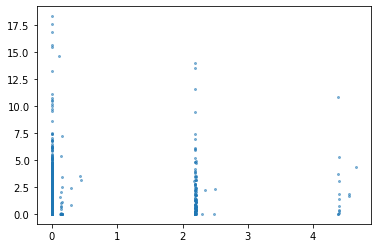

In [138]:
#%matplotlib inline
from sklearn.decomposition import NMF
from sklearn.preprocessing import PowerTransformer
  
scaler=PowerTransformer(method='yeo-johnson')
scaler.fit(datos_col)
X=scaler.transform(datos_col)

pca=PCA()
pca.fit(X)
X_pca=pca.transform(X) 

nmf=NMF()
nmf.fit(datos_col)
X_nmf=nmf.transform(datos_col) 

print(pca.explained_variance_ratio_)

#print(nmf.explained_variance_ratio_)
plt.scatter(X_nmf[:,0],X_nmf[:,1],s=4,alpha=.5)

In [ ]:
sns.

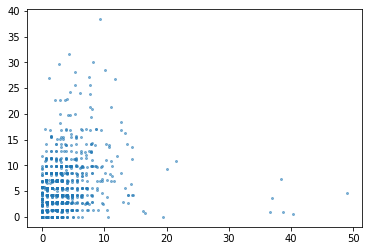

In [96]:
plt.scatter(X_nmf[:,0],X_nmf[:,2],s=4,alpha=.5)
#plt.scatter(X_nmf[:,1],X_nmf[:,2],s=4,alpha=.5)
#plt.scatter(X_nmf[:,2],X_nmf[:,3],s=4,alpha=.5)


In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

In [81]:
nmf

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

Mapeando el índice de inseguridad en el mapa de la ciudad, se observa lo siguiente:
- Hay mayor inseguridad al norte dle centro y al este de la ciudad.
- Un foco rojo es la central de abastos
- Resalta la zona del centro histórico
- Hay cierta concentración al este de la central de abastos. Esto corresponde a Santa Marta, en la calzada de Zaragoza y en la frontera con el Estado de México.

In [296]:
pd.DataFrame({'cve_col':datos_col.index,'PCA':X_pca[:,0]})

cve_col       PCA
0    02-005  1.093480
1    02-008  0.409290
2    02-024 -1.413018
3    02-025  1.121478
4    02-026 -0.657137
5    02-028  1.121478
6    02-036 -0.862745
7    02-040 -1.413018
8    02-045 -1.413018
9    02-049  1.121478
10   02-056  0.409290
11   02-060 -1.413018
12   02-064  1.121478
13   02-071 -1.413018
14   02-074  1.121478
15   02-079 -1.413018
16   02-097  1.671751
17   02-098 -1.413018
18   02-099  0.409290
19   02-101 -1.413018
20   02-102 -0.458180
21   02-104  0.057974
22   02-108  1.121478
23   02-110 -0.657137
24   02-111 -1.413018
25   03-012  2.524653
26   03-021 -0.150557
27   03-030 -1.636318
28   03-034  1.121478
29   03-037 -1.413018
..      ...       ...
394  16-093 -0.150557
395  16-094 -0.373512
396  16-095 -2.703911
397  17-002  2.381747
398  17-007  1.121478
399  17-015 -1.413018
400  17-021 -1.413018
401  17-022  1.121478
402  17-026  0.018155
403  17-031 -0.544416
404  17-036  1.121478
405  17-038  1.408766
406  17-042  0.399716
407  17-046  0.348299
408  17-047  1.121478
409  17-053  1.121478
410  17-055  0.605325
411  17-058  0.856448
412  17-061 -0.150557
413  17-066  1.121478
414  17-067  1.121478
415  17-069 -1.413018
416  17-070  2.552651
417  17-073  1.408766
418  17-074  0.057974
419  17-075 -1.413018
420  17-076  1.408766
421  17-079 -0.401511
422  17-080  1.121478
423  17-083  1.121478

[424 rows x 2 columns]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


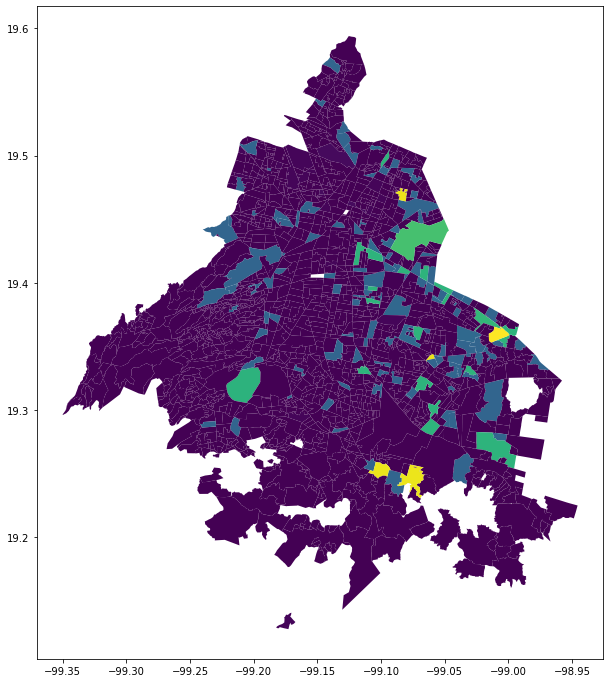

In [100]:
mapa_col.merge(pd.DataFrame({'cve_col':datos_col.index,'PCA':X_nmf[:,3]}),
           on='cve_col',how='left')\
    .plot(column='PCA',figsize=(15,12))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


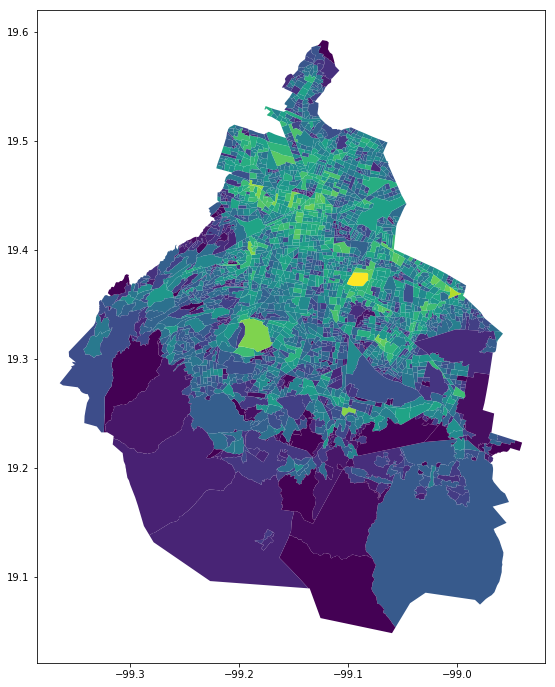

In [19]:
mapa.merge(pd.DataFrame({'CVEGEO':datos_pv.index,'PCA':X_pca[:,0]}),
           on='CVEGEO',how='left').plot(column='PCA',figsize=(15,12))

### 12) Toma los delitos clasificados como “Robo a pasajero a bordo de transporte público con y sin violencia”. ¿Cuáles son las ruta de transporte público donde más ocurren estos delitos?

Comparando la ubicación de los delitos con el mapa de RTP (https://www.rtp.cdmx.gob.mx/red-de-rutas), se observa lo siguiente:
- A lo largo de toda la calzada Ignacio Zaragoza se registran asaltos.
- La mayor concentración de casos se encuentra en la Central de Abasto, y su rastro se extiende a lo largo de Río Churubusco
- Hay cierta aglomeración en la avenida FC de Hidalgo, cerca de la UCTM Atzacoalco
- Hay cierta aglomeración en la calzada Mariano Escobedo

In [23]:
set(datos['categoria_delito'])

{'DELITO DE BAJO IMPACTO',
 'HECHO NO DELICTIVO',
 'HOMICIDIO DOLOSO',
 'LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO',
 'ROBO A CASA HABITACIÓN CON VIOLENCIA',
 'ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA',
 'ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA',
 'ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
 'ROBO A REPARTIDOR CON Y SIN VIOLENCIA',
 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA',
 'ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA',
 'ROBO DE VEHÍCULO CON Y SIN VIOLENCIA',
 'SECUESTRO',
 'VIOLACIÓN'}

In [24]:
mini_datos=datos[datos['categoria_delito']=='VIOLACIÓN']\
    .reset_index().drop(columns='index')

In [27]:
mini_datos.head()

ao_hechos mes_hechos      fecha_hechos     delito categoria_delito  \
0     2018.0      Abril  2018-04-01 03:15  VIOLACION        VIOLACIÓN   
1     2018.0      Abril  2018-04-03 01:00  VIOLACION        VIOLACIÓN   
2     2018.0      Abril  2018-04-04 17:15  VIOLACION        VIOLACIÓN   
3     2018.0      Abril  2018-04-06 15:30  VIOLACION        VIOLACIÓN   
4     2018.0      Abril  2018-04-08 01:30  VIOLACION        VIOLACIÓN   

                                            fiscalia agencia  \
0  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...   FDS-1   
1  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...   FDS-6   
2  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...   FDS-2   
3  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...   FDS-2   
4  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS SEXU...   FDS-3   

  unidad_investigacion        alcaldia_hechos                colonia_hechos  \
0             FDS-1-02             CUAUHTEMOC                    ROMA NORTE   
1             FDS-6-02               COYOACAN  PUEBLO DE SANTA URSULA COAPA   
2             FDS-2-02  CUAJIMALPA DE MORELOS                    ZENTLAPATL   
3             FDS-2-01               COYOACAN                           NaN   
4             FDS-3-03    VENUSTIANO CARRANZA                       MORELOS   

   ao_inicio mes_inicio      fecha_inicio  \
0       2018      Abril  2018-04-01 22:56   
1       2018      Abril  2018-04-04 13:44   
2       2018      Abril  2018-04-04 21:17   
3       2018      Abril  2018-04-07 01:48   
4       2018      Abril  2018-04-08 15:22   

                                    calle_hechos calle_hechos2   longitud  \
0                                 AVENIDA OAXACA           NaN -99.167233   
1                                       ESFUERZO     TLAPACOYA -99.142705   
2  (LA COL. LA VENTA NO ESTA MARCADA EN EL MAPA)           NaN -99.313401   
3                            SIN DATOS EN EL SAP           NaN        NaN   
4                              NO PRECISA CALLES           NaN -99.121405   

     latitud                      geopoint       fecha     mes_ano  
0  19.418709  19.4187090081,-99.1672325612  2018-04-01  2018-04-01  
1  19.311362  19.3113622721,-99.1427045034  2018-04-03  2018-04-01  
2  19.333331  19.3333310164,-99.3134014833  2018-04-04  2018-04-01  
3        NaN                           NaN  2018-04-06  2018-04-01  
4  19.443593  19.4435932172,-99.1214045033  2018-04-08  2018-04-01

In [25]:
points = gpd.GeoDataFrame(mini_datos[['longitud','latitud','categoria_delito','delito']], geometry=gpd.points_from_xy(mini_datos['longitud'],mini_datos['latitud']))

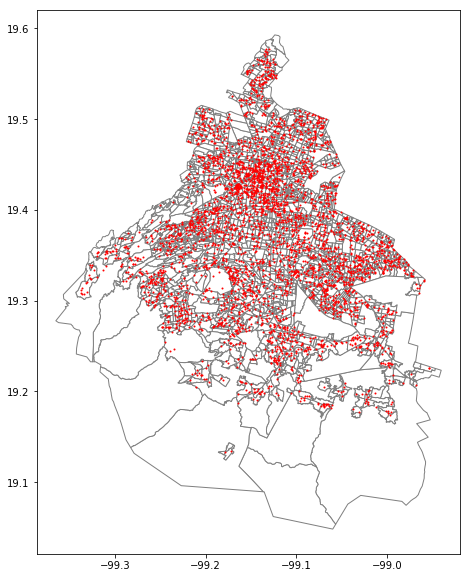

In [26]:
ax=mapa.plot(color='white',figsize=(12,10), edgecolor='grey')
points.plot(ax=ax, color='red',markersize=1)
plt.show()

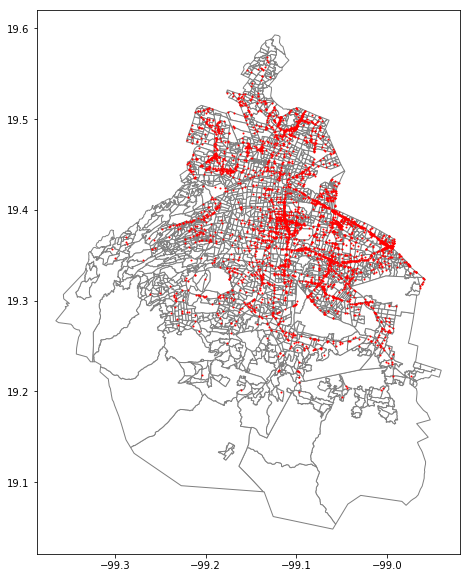

In [22]:
ax=mapa.plot(color='white',figsize=(12,10), edgecolor='grey')
points.plot(ax=ax, color='red',markersize=1)
plt.show()

![title](red_rtp.png)

### 2) ¿Cuántos delitos registrados hay en la tabla? ¿Qué rango de tiempo consideran los datos?

In [10]:
print('Total de registros: ' + str((datos.shape[0])))
print('Periodo considerado: ' + str(min(datos['fecha'])) + ' a ' + str(max(datos['fecha'])))

Total de registros: 355213
Periodo considerado: 2019-02-01 a 2020-09-30


In [ ]:
Una vez determinado nuestro espacio muestral, pasamos a observar la incidencia de delitos por categoría.

### 3) ¿Cómo se distribuye el número de delitos en la CDMX? ¿Cuáles son los 5 delitos más frecuentes?

In [14]:
#sorted(Counter(datos['delito']).items(), key=lambda i: i[1], reverse=True)
plt.bar(Counter(datos['categoria_delito']).items())

TypeError: bar() missing 1 required positional argument: 'height'

In [15]:
help(Counter)

Help on class Counter in module collections:

class Counter(builtins.dict)
 |  Counter(*args, **kwds)
 |  
 |  Dict subclass for counting hashable items.  Sometimes called a bag
 |  or multiset.  Elements are stored as dictionary keys and their counts
 |  are stored as dictionary values.
 |  
 |  >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
 |  
 |  >>> c.most_common(3)                # three most common elements
 |  [('a', 5), ('b', 4), ('c', 3)]
 |  >>> sorted(c)                       # list all unique elements
 |  ['a', 'b', 'c', 'd', 'e']
 |  >>> ''.join(sorted(c.elements()))   # list elements with repetitions
 |  'aaaaabbbbcccdde'
 |  >>> sum(c.values())                 # total of all counts
 |  15
 |  
 |  >>> c['a']                          # count of letter 'a'
 |  5
 |  >>> for elem in 'shazam':           # update counts from an iterable
 |  ...     c[elem] += 1                # by adding 1 to each element's count
 |  >>> c['a']                          #

In [21]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The vertical baseline
    is *bottom* (default 0).
    
    Each of *x*, *height*, *width*, and *bottom* may either be a scalar
    applying to all bars, or it may be a sequence of length N providing a
    separate value for each bar.
    
    Parameters
    ----------
    x : sequence of scalars
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : scalar or sequence of scalars
        The height(s) of the bars.
    
    width : scalar or array-like, optional
        The width(s) of the bars (default: 0.8).
    
    bottom : scalar or array-like, optional
        The y coordinate(s) of the bars bases (default: 0).
    
    align : {'cent

<BarContainer object of 16 artists>

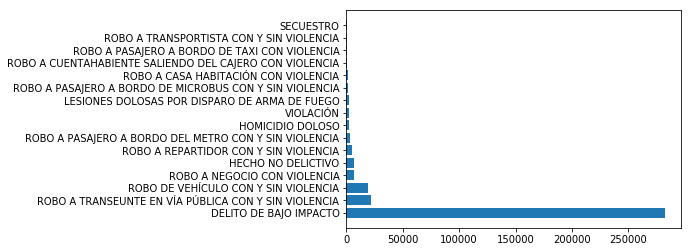

In [27]:
plt.barh(datos['categoria_delito'].value_counts().index,datos['categoria_delito'].value_counts().values)

Dado que los delitos de bajo impacto scsdcsdcs, descartaremos dichas observaciones para nuestro análisis.

In [ ]:
datos=datos[datos['categoria_delito']!='DELITO DE BAJO IMPACTO']

<BarContainer object of 15 artists>

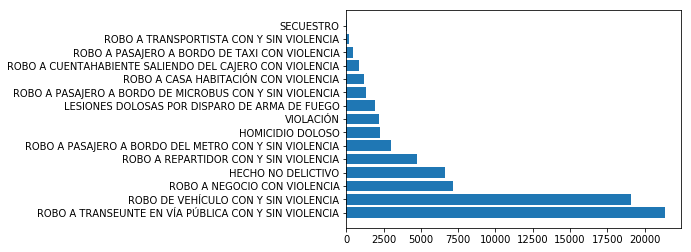

In [32]:
plt.barh(datos.loc[datos['categoria_delito']!='DELITO DE BAJO IMPACTO','categoria_delito'].value_counts().index,
         datos.loc[datos['categoria_delito']!='DELITO DE BAJO IMPACTO','categoria_delito'].value_counts().values)

# Extra

### 5) ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?.¿Por qué crees que sea esto?

Cuauhtémoc y Milpa Alta.

Por la densidad de población. Por un lado hace que aunque la tasa de dlitos sea constante el total absoluto sea más grande.
Por otro lado, puede considerarse un proxy de hacinamiento, lo que suele estar relacionado a mayor incidencia delictiva.

In [10]:
datos[['alcaldia_hechos','delito']].groupby('alcaldia_hechos').count().sort_values(by='delito',ascending=False)

delito
alcaldia_hechos               
CUAUHTEMOC              163092
IZTAPALAPA              159544
GUSTAVO A MADERO        106058
BENITO JUAREZ            88701
ALVARO OBREGON           71123
COYOACAN                 70417
MIGUEL HIDALGO           68984
TLALPAN                  61660
VENUSTIANO CARRANZA      61338
AZCAPOTZALCO             51175
IZTACALCO                44393
XOCHIMILCO               32721
TLAHUAC                  25124
LA MAGDALENA CONTRERAS   16572
CUAJIMALPA DE MORELOS    15178
MILPA ALTA                7125

### 6) Dentro de cada alcaldía, cuáles son las tres colonias con más delitos

In [11]:
datos[['alcaldia_hechos','colonia_hechos','delito']]\
    .groupby(['alcaldia_hechos','colonia_hechos']).count().reset_index().sort_values(by='delito',ascending=False)\
    .groupby('alcaldia_hechos').head(3).sort_values(by='alcaldia_hechos')

alcaldia_hechos                    colonia_hechos  delito
256           ALVARO OBREGON                    ZEDEC SANTA FE    2436
220           ALVARO OBREGON                         SAN ANGEL    2576
118           ALVARO OBREGON             JARDINES DEL PEDREGAL    3179
268             AZCAPOTZALCO            CENTRO DE AZCAPOTZALCO    2221
288             AZCAPOTZALCO                INDUSTRIAL VALLEJO    2422
278             AZCAPOTZALCO                        EL ROSARIO    3690
368            BENITO JUAREZ                  DEL VALLE CENTRO   15353
384            BENITO JUAREZ                          NARVARTE   11468
391            BENITO JUAREZ                      PORTALES SUR    5860
409                 COYOACAN                            AJUSCO    3250
498                 COYOACAN         PEDREGAL DE SANTO DOMINGO    6081
497                 COYOACAN          PEDREGAL DE SANTA URSULA    3202
578    CUAJIMALPA DE MORELOS            SAN JOSÉ DE LOS CEDROS    1456
571    CUAJIMALPA DE MORELOS                 LOMAS DE SANTA FE    2181
554    CUAJIMALPA DE MORELOS                        CUAJIMALPA    2255
593               CUAUHTEMOC                            CENTRO   34590
611               CUAUHTEMOC                        ROMA NORTE   12839
597               CUAUHTEMOC                          DOCTORES   18810
701         GUSTAVO A MADERO                 GUADALUPE TEPEYAC    4376
768         GUSTAVO A MADERO               SAN FELIPE DE JESÚS    3120
733         GUSTAVO A MADERO                        LINDAVISTA    4719
817                IZTACALCO                 AGRÍCOLA ORIENTAL    8611
818                IZTACALCO                AGRÍCOLA PANTITLAN    7141
830                IZTACALCO                    GRANJAS MÉXICO    4670
981               IZTAPALAPA              LOMAS DE SAN LORENZO    3955
903               IZTAPALAPA                 CENTRAL DE ABASTO    7157
914               IZTAPALAPA    DESARROLLO URBANO QUETZALCOATL    3939
1134  LA MAGDALENA CONTRERAS             SAN NICOLÁS TOTOLAPAN    1387
1130  LA MAGDALENA CONTRERAS              SAN BERNABÉ OCOTEPEC     949
1133  LA MAGDALENA CONTRERAS               SAN JERÓNIMO LÍDICE    1879
1212          MIGUEL HIDALGO                            TACUBA    3878
1151          MIGUEL HIDALGO                           ANAHUAC    4880
1198          MIGUEL HIDALGO                           POLANCO    8903
1220              MILPA ALTA  CRUZTITLA (SAN ANTONIO TECOMITL)     491
1256              MILPA ALTA   SANTA MARTHA (VILLA MILPA ALTA)     447
1249              MILPA ALTA  SAN MIGUEL (SAN PABLO OZTOTEPEC)     468
1272                 TLAHUAC                           DEL MAR    1516
1306                 TLAHUAC                    MIGUEL HIDALGO    1507
1317                 TLAHUAC           SAN FRANCISCO TLALTENCO    1212
1501                 TLALPAN             SAN ANDRÉS TOTOLTEPEC    4089
1409                 TLALPAN                HÉROES DE PADIERNA    2384
1533                 TLALPAN                  TLALPAN CENTRO I    2258
1607     VENUSTIANO CARRANZA                   JARDÍN BALBUENA    5733
1615     VENUSTIANO CARRANZA              MOCTEZUMA 2A SECCIÓN    4673
1639     VENUSTIANO CARRANZA                       ZONA CENTRO    4174
1735              XOCHIMILCO            SAN GREGORIO ATLAPULCO    2125
1751              XOCHIMILCO     SANTA CRUZ ACALPIXCA - PUEBLO    1695
1758              XOCHIMILCO           SANTIAGO TEPALCATLALPAN    1671

### 7) ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la semana, quincenas)?

Tomando los datos a partir de 2018 se puede observar una estacionalidad con una longitud de onda relativamente corta, sugiriendo algo **semanal**. Haciendo zoom para un par de meses confirmamos dicha sospecha.

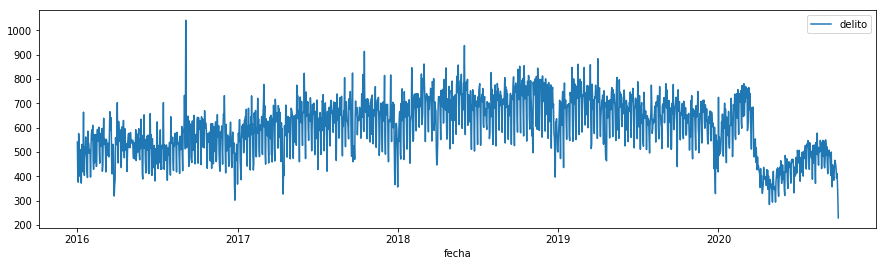

In [50]:
datos.loc[ (datos['fecha']>datetime.strptime('01-01-2018','%d-%m-%Y').date()) & 
          (datos['fecha']<datetime.strptime('01-01-2021','%d-%m-%Y').date()),
          ['fecha','delito']].groupby('fecha').count().plot(figsize=(15,4))

![title](red_rtp.png)